# DoWhy: 因果效应估计方法

这是DoWhy因果推理库的快速介绍。我们将加载样本数据集，并使用不同的方法来估计治疗变量对结果变量的因果效应。

In [1]:
# 首先，让我们为Python添加所需的路径以找到DoWhy代码并加载所有必需的包。

import os, sys
sys.path.append(os.path.abspath("../../../"))

import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

现在，让我们加载一个数据集。为简单起见，我们模拟了一个数据集，该数据集具有 common causes and treatment 以及 common causes and outcome。 

Beta是真正的因果效应。

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.074007,0.320359,-0.911507,0.687244,-1.131383,-2.030433,True,-1.060587
1,1.0,0.704473,0.874747,-1.360272,1.186362,-0.290832,2.292298,True,21.703056
2,1.0,0.557839,0.703372,0.706298,0.590293,-0.307522,0.256108,True,13.595556
3,1.0,0.676542,0.236206,1.242125,0.911646,-0.288688,0.645965,True,15.822736
4,0.0,0.060643,-1.948207,0.043145,0.898002,-1.309606,0.808092,False,-1.319757
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.695220,0.353565,-0.135555,-0.391446,-0.560407,2.194757,True,18.045915
9996,0.0,0.609236,1.241908,1.008234,0.319823,-1.682370,0.632018,True,12.580721
9997,1.0,0.627910,0.059145,-0.353845,-0.204611,-1.326773,-0.080444,True,5.582184
9998,1.0,0.103305,0.009746,-1.051855,0.851757,0.520835,0.557877,True,14.225046


> 识别因果估计量

现在，我们以DOT图格式输入因果图。

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"],
        logging_level = logging.INFO
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


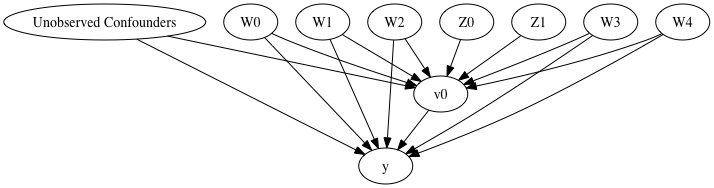

In [4]:
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'W4', 'W1', 'W2', 'W3', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



## 方法1：回归

Use linear regression.

In [6]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W1+W2+W3+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W1+W2+W3+W0
## Estimate
Value: 10.000000000000098

## Statistical Significance
p-value: <0.001

Causal Estimate is 10.000000000000098


## 方法2：分层

我们将使用倾向得分对数据进行分层。

In [7]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W1+W2+W3+W0
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W1+W2+W3+W0
## Estimate
Value: 9.891937050418353

Causal Estimate is 9.891937050418353


## 方法3：匹配

We will be using propensity scores to match units in the data.

In [8]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W1+W2+W3+W0
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:77: FutureWarning: `item` has been deprecated and will be removed in a future version
  treated_outcome = treated.iloc[indices[i]][self._outcome_name].item()


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W1+W2+W3+W0
## Estimate
Value: 10.166789027060684

Causal Estimate is 10.166789027060684


## 方法4：加权方法

我们将基于(inverse)倾向得分为数据分配权重。DoWhy支持几种不同的加权方案：

1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [9]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W1+W2+W3+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W1+W2+W3+W0
## Estimate
Value: 13.94568800467214

Causal Estimate is 13.94568800467214


/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 方法5：工具变量法

我们将使用 Wald 估计量 for the provided instrumental variable.

In [10]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W3,W0,U) = P(y|v0,W4,W1,W2,W3,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z

## 方法6：断点回归法

We will be internally converting this to an equivalent instrumental variables problem.

In [12]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.1})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
2              0.557839             True      13.595556
5              0.568788             True      16.770239
8              0.579601             True       9.256124
12             0.512447             True      16.020636
16             0.401104             True      11.293649
...                 ...              ...            ...
9963           0.471563             True       4.697192
9970           0.502436             True      23.472817
9978           0.437047             True      13.123166
9980           0.458688             True       2.881852
9994           0.413953             True      15.189475

[1920 rows x 3 columns]
*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} an